In [3]:
import numpy as np
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, sobol, fast_sampler
from SALib.analyze import sobol, fast
import seaborn as sns
import SALib
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve
from scipy.constants import N_A

In [4]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*10
t = np.geomspace(1e-10, t_end, 20)
tspan = [1e-10, t_end]
z0 = [0, 0, 0]
z01 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
reaction_volume = (2/3)*math.pi*((r_ab)**3)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [5]:
N_A*well_size/Target_cell_number

451660557000000.0

In [6]:
def model_S_bispecific(t, z, Ainit, rtot1, rtot2, kon, kon1, k21, k22, koff1, koff2):
    k = Ainit*kon
    k1 = Ainit*kon1
    Atot = well_size*N_A*Ainit/Target_cell_number
    A0 = Atot - z[0] - z[1] - z[2]
    Ag1 = rtot1 - z[0] - z[2]
    Ag2 = rtot2 - z[1] - z[2]

    dA10 = (k*(Ag1)*(A0)/rtot1) - koff1*z[0] - (k22*(Ag2)*z[0]/rtot2) + koff2*z[2]
    dA01 = (k1*(Ag2)*(A0)/rtot2) - koff2*z[1] - (k21*(Ag1)*z[1]/rtot1) + koff1*z[2]
    dA11 = (k22*(Ag2)*z[0]/rtot2) + (k21*(Ag1)*z[1]/rtot1) - (koff1 + koff2)*z[2]

    return [dA10, dA01, dA11]

def model_S_monospecific(t, z, Ainit, rtot, kon, k2, koff, dummy):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/Atot) - koff*z[0] - (k2*Ag*z[0]/1) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]/1) - 2*koff*z[1]

     return [dA10, dA11]

def solve_ode_monospecific(Ainit, rtot, kon, k2, koff, dummy):

    z = solve_ivp(model_S_monospecific, tspan, z01, method='Radau', t_eval=t, args=(Ainit, rtot, kon, k2, koff, dummy))

    A10 = z.y[0]
    A11 = z.y[1]
    A10_STST = A10[-1]
    A11_STST = A11[-1]

    Ag = (A11_STST)/rtot
    return Ag

def solve_ode_bispecific(Ainit, rtot1, rtot2, kon1, kon2, k21, k22, koff1, koff2):

    z = solve_ivp(model_S_bispecific, tspan, z0, method='Radau', t_eval=t, args=(Ainit, rtot1, rtot2, kon1, kon2, k21, k22, koff1, koff2))

    A10 = z.y[0]
    A01 = z.y[1]
    A11 = z.y[2]
    A10_STST = A10[-1]
    A01_STST = A01[-1]
    A11_STST = A11[-1]

    Ag1 = (rtot1 - A10_STST - A11_STST)/rtot1
    Ag2 = (rtot2 - A01_STST - A11_STST)/rtot2
    Ab = 1 - (((rtot1 - A10_STST - A11_STST) + (rtot2 - A01_STST - A11_STST))/(rtot1 + rtot2))

    return [Ag1, Ag2, Ab]

def A1_steady_state(x, Ainit, k1, koff, k2, rtot, dummy):
    Atot = well_size*N_A*Ainit/Target_cell_number
    express = (-2*Atot*k1*Ainit*(rtot - x)*(koff*rtot + k2*x) + x*(((koff*rtot + k2*x)**2) +k1*Ainit*(rtot - x)*(2*koff*rtot + k2*(rtot+x))))/((koff*rtot + k2*x)**2)

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff*rtot + k2*x))

    return express

def A1_steady_state_unnormalised(x, Ainit, k1, koff, k2, rtot, dummy):
    Atot = well_size*N_A*Ainit/Target_cell_number
    express = (-2*Atot*k1*Ainit*(rtot - x)*(koff*rtot + k2*x) + x*(((koff*rtot + k2*x)**2) +k1*Ainit*(rtot - x)*(2*koff*rtot + k2*(rtot+x))))/((koff*rtot + k2*x)**2)

    return express

def A2_steady_state_unnormalised(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff*rtot + k2*x))

    return express

4.973591971621729e-05


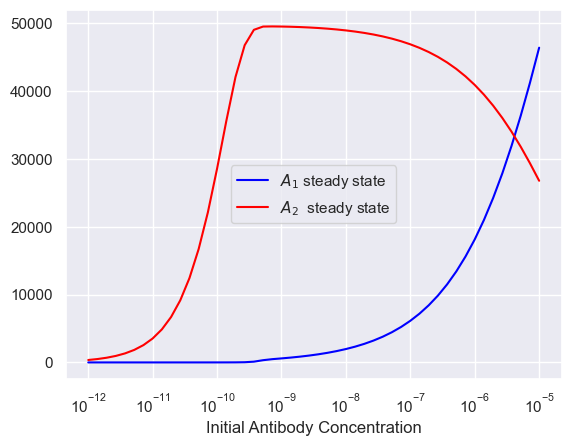

In [19]:
A0s = np.geomspace(1e-12, 1e-5, 50)

A1_st_sim = np.zeros_like(A0s)
A1_st_root = np.zeros_like(A0s)
A2_st_sim = np.zeros_like(A0s)
A2_st_root = np.zeros_like(A0s)
D = 1e-14
k2 = 4*D/tumour_cell_surface_area
print(k2)
for i, Ainit in enumerate(A0s):

    A1_st_root[i] = fsolve(A1_steady_state, [1e-5], args=(Ainit, 1e5, 1e-1, 1e1, 1e7, 0))
    A2_st_root[i] = A2_steady_state(A1_st_root[i], 1e1, 1e-1, 1e7)
    z = solve_ivp(model_S_monospecific, tspan, [0,0], method='Radau', t_eval=t, args=(Ainit, 1e5, 1e5, k2, 1e-4, 0))
    A1 = z.y[0]
    A2 = z.y[1]
    A1_st_sim[i] = A1[-1]
    A2_st_sim[i] = A2[-1]

sns.set_theme()
plt.plot(A0s, A1_st_sim, label = r'$A_1$' + ' steady state', color='blue')
#plt.plot(A0s, A1_st_root, label = 'A1 calculated root')
plt.plot(A0s, A2_st_sim, label = r'$A_2$ ' + ' steady state', color='red')
#plt.plot(A0s, A2_st_root, label = 'A2 calculated root')

plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('Initial Antibody Concentration')
plt.show()

In [8]:
problem = {
    'num_vars': 8,
    'names': ['rtot1', 'rtot2', 'kon1', 'kon2', 'k21', 'k22', 'koff1', 'koff2'],
    'bounds': [[1e3, 1e7],
               [1e3, 1e7],
               [1e4, 1e6],
               [1e4, 1e6],
               [1e3, 1e7],
               [1e3, 1e7],
               [1e-6, 1e-1],
               [1e-6, 1e-1]]
}

problem1 = {
    'num_vars': 5,
    'names': ['rtot', 'kon', 'k2', 'koff', 'dummy'],
    'bounds': [[1e3, 1e7],
               [1e4, 1e6],
               [1, 1e4],
               [1e-6, 1e-1],
               [1, 1000]]
}

problem2 = {
    'num_vars': 4,
    'names': ['kon', 'k2', 'koff', 'dummy'],
    'bounds': [[1e3, 1e7],
               [1e4, 1e6],
               [1e-6, 1e-1],
               [1, 1000]]
}


vals = SALib.sample.sobol.sample(problem1, 65536, scramble=True)
Y_ag1 = np.zeros(len(vals))
Y_ag2 = np.zeros(len(vals))
Y_ab = np.zeros(len(vals))
indicies_ag1 = []
indicies_ag2 = []
indicies_ab = []
A0s = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
Y = np.zeros(len(vals))
indicies = []
indicies_1 = []

In [9]:
sol_holder = []
for Ainit in A0s:
    print(Ainit)
    for i, params in enumerate(vals):
     
        rtot = params[0]
        kon = params[1]
        k2 = params[2]
        koff = params[3]
        dummy = params[4]

        if Ainit < 1e-8:
            guess = 1e-7
        else:
            guess = 100

        A1_st = fsolve(A1_steady_state, [guess], args=(Ainit, kon, koff, k2, rtot, dummy))
        A2_st = A2_steady_state(A1_st, k2, koff, rtot)
        Ag =(A1_st + 2*A2_st)/rtot
        Y[i] = Ag
    
    Si = sobol.analyze(problem1, Y)
    indicies.append(Si['ST'])
    indicies_1.append(Si['S1'])


1e-11


KeyboardInterrupt: 

7


Text(0, 0.5, 'Total Order Sobol Indicies')

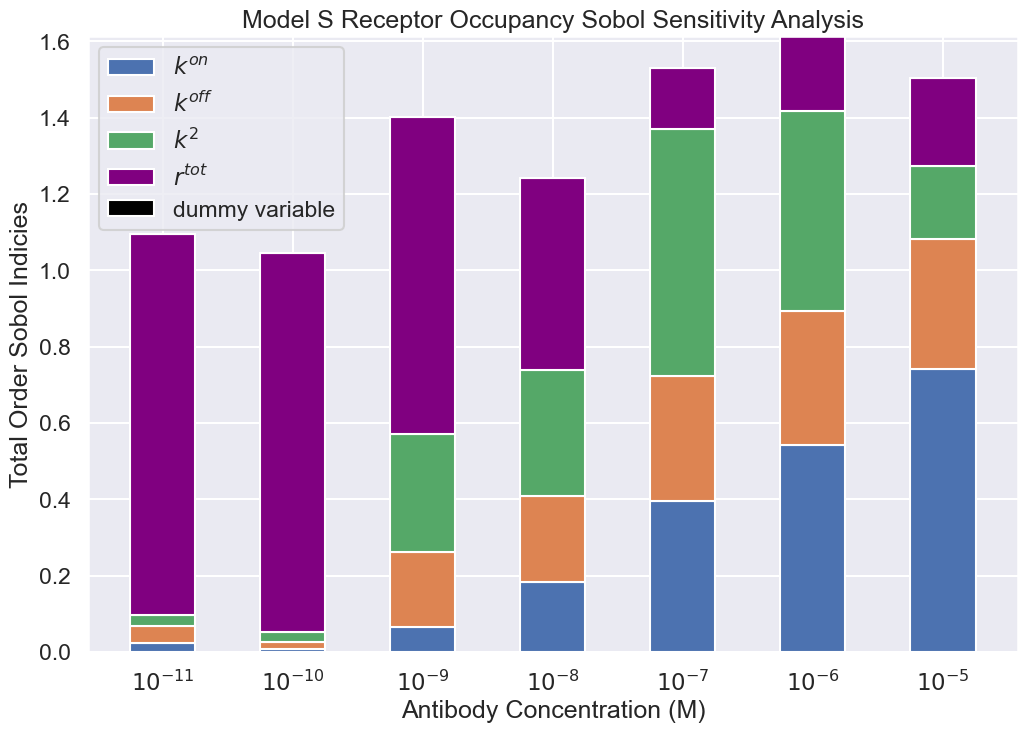

In [ ]:
kon1_si = np.zeros(len(A0s))
koff1_si = np.zeros(len(A0s))
kon2_si = np.zeros(len(A0s))
koff2_si = np.zeros(len(A0s))
k21_si = np.zeros(len(A0s))
k22_si = np.zeros(len(A0s))
rtot1_si = np.zeros(len(A0s))
rtot2_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))

for i in range(len(indicies)):
    vals = indicies[i]
    rtot1_si[i] = vals[0]
    kon1_si[i] = vals[1]
    k21_si[i] = vals[2]
    koff1_si[i] = vals[3]
    dummy_si[i] = vals[4]

print(len(indicies))
ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')

param_indicies = {
    r"$k^{on}$": kon1_si,
    r"$k^{off}$": koff1_si,
    r"$k^{2}$": k21_si,
    
}

sns.set_theme()
sns.set_context("talk")

width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

for boolean, param_indicie in param_indicies.items():
    p = ax.bar(ab_conc, param_indicie, width, label=boolean, bottom=bottom)
    bottom += param_indicie
ax.bar(ab_conc, rtot1_si, width, label=r'$r^{tot}$', bottom= bottom, color='purple')
bottom+= rtot1_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.set_title('Model S Receptor Occupancy Sobol Sensitivity Analysis')
ax.legend(loc='best')
ax.set_xlabel('Antibody Concentration (M)')
ax.set_ylabel('Total Order Sobol Indicies')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_s_bispecific_total_ab_sensiv_analysis.png')

Text(0, 0.5, 'First Order Sobol Indicies')

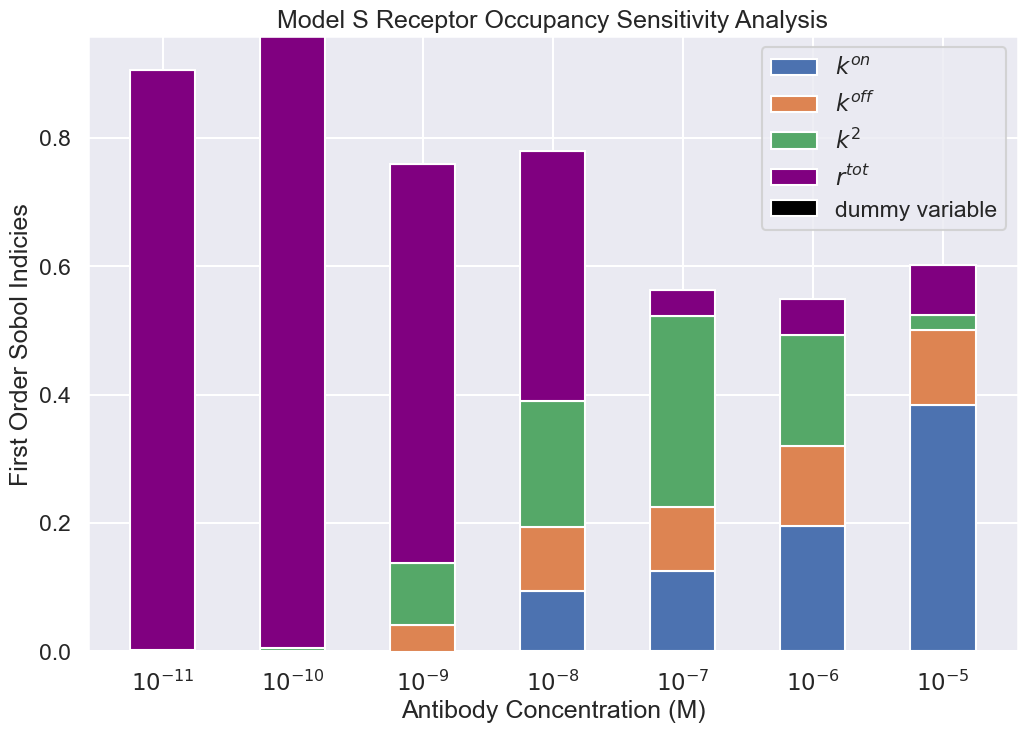

In [ ]:
kon1_si = np.zeros(len(A0s))
koff1_si = np.zeros(len(A0s))
kon2_si = np.zeros(len(A0s))
koff2_si = np.zeros(len(A0s))
k21_si = np.zeros(len(A0s))
k22_si = np.zeros(len(A0s))
rtot1_si = np.zeros(len(A0s))
rtot2_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))

for i in range(len(indicies_1)):
    vals = indicies_1[i]
    rtot1_si[i] = vals[0]
    kon1_si[i] = vals[1]
    k21_si[i] = vals[2]
    koff1_si[i] = vals[3]
    dummy_si[i] = vals[4]


ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')

param_indicies = {
    r"$k^{on}$": kon1_si,
    r"$k^{off}$": koff1_si,
    r"$k^{2}$": k21_si,
    
}

sns.set_theme()
sns.set_context("talk")

width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

for boolean, param_indicie in param_indicies.items():
    p = ax.bar(ab_conc, param_indicie, width, label=boolean, bottom=bottom)
    bottom += param_indicie
ax.bar(ab_conc, rtot1_si, width, label=r'$r^{tot}$', bottom= bottom, color='purple')
bottom+= rtot1_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.set_title('Model S Receptor Occupancy Sensitivity Analysis')
ax.legend(loc='best')
ax.set_xlabel('Antibody Concentration (M)')
ax.set_ylabel('First Order Sobol Indicies')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_s_bispecific_total_ab_sensiv_analysis.png')